## Key findings and achievements

> * Computed RFMT features from a retail purchase dataset, for customer segmentation analysis.
> * Preprocessed and normalized the dataset to enable optimal clustering, and determined the most suitable number of clusters (k) using the Elbow Method.
> * Executed a comparative analysis of two KMeans clustering solutions, providing a clear distinction between the customer groups for k=n and k=n+1.
> * Interpreted each cluster to define distinct business personas, leading to the identification of strategic, customized actions aimed at enhancing customer engagement and business growth.

---

## Introduction
In today's competitive marketplace, leveraging data to understand and predict customer behavior is paramount for sustaining growth and securing a strategic advantage. Customer clustering analysis stands at the forefront of this endeavor, offering a powerful suite of techniques for unraveling the complexities of customer data. By partitioning customers into distinct groups, or clusters, based on shared attributes, businesses can tailor their marketing strategies, optimize resource allocation, and ultimately drive a more personalized customer experience.

The core aim of this analytical notebook is to perform an in-depth clustering analysis of retail customers, with a focus on RFMT attributes. By dissecting the nuanced behaviors captured within these features, we aspire to unearth distinct customer segments that can reveal targeted opportunities for enhanced marketing engagement, optimized product placement, and improved customer lifetime value.

In [36]:
#| echo: false
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

The dataset we are utilizing for this exercise is a classic example of transactional data commonly encountered across various business sectors. It represents purchase data from an online retail business based in the UK. Each record in this dataset corresponds to a single purchase transaction made by a customer. This type of dataset is ubiquitous in the business world, providing invaluable insights into customer behavior.

Our dataset is structured as follows:

In [37]:
#| echo: false
df = pd.read_parquet('../../data/concatenated_online_retail_II.parquet') \
                    .rename(columns={'Customer ID': 'CustomerID'})
df['Amount'] = df['Price'] * df['Quantity']
df = df[df['Amount'] > 0]
display(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1041671 entries, 0 to 1067370
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1041671 non-null  string        
 1   StockCode    1041671 non-null  string        
 2   Description  1041671 non-null  string        
 3   Quantity     1041671 non-null  int64         
 4   InvoiceDate  1041671 non-null  datetime64[us]
 5   Price        1041671 non-null  float64       
 6   CustomerID   805549 non-null   float64       
 7   Country      1041671 non-null  string        
 8   Year         1041671 non-null  int64         
 9   Amount       1041671 non-null  float64       
dtypes: datetime64[us](1), float64(3), int64(2), string(4)
memory usage: 87.4 MB


None

,Quantity,InvoiceDate,Price,CustomerID,Year,Amount
count,1.041671e+06,1041671,1.041671e+06,805549.000000,1.041671e+06,1.041671e+06
mean,1.096345e+01,2011-01-03 16:31:26.403269,4.077038e+00,15331.954970,1.508899e+00,2.013397e+01
min,1.000000e+00,2009-12-01 07:45:00,1.000000e-03,12346.000000,1.000000e+00,1.000000e-03
25%,1.000000e+00,2010-07-12 10:26:00,1.250000e+00,13982.000000,1.000000e+00,3.900000e+00
50%,3.000000e+00,2010-12-07 15:33:00,2.100000e+00,15271.000000,2.000000e+00,9.960000e+00
75%,1.000000e+01,2011-07-24 12:05:00,4.130000e+00,16805.000000,2.000000e+00,1.770000e+01
max,8.099500e+04,2011-12-09 12:50:00,2.511109e+04,18287.000000,2.000000e+00,1.684696e+05
std,1.265149e+02,NaN,5.144898e+01,1696.737039,4.999210e-01,2.031167e+02


The columns include basic transactional elements like Invoice number, StockCode, product Description, Quantity, and Amount of items purchased, InvoiceDate, Price of the items, CustomerID, Country of purchase, and the Year of the transaction.

## Computing Recency, Frequency, Monetary Value, and Tenure
The RFMT model is a cornerstone of customer value analysis, providing a multifaceted framework to quantify and understand customer behavior. In this phase of our analysis, we will compute the four key metrics that comprise the RFMT model:

* **Recency** (R): The freshness of customer engagement, measured by the time since the last transaction. This metric helps us understand which customers have interacted with the business recently, indicating an ongoing relationship.

* **Frequency** (F): The rate of transactions, determined by the number of purchases made within a specific period. This dimension allows us to identify the most engaged customers who transact with the business regularly.

* **Monetary Value** (M): The total spend of a customer, calculated by summing up the value of all purchases. This metric highlights the customers who contribute the most to revenue and can indicate potential for future profitability.

* **Tenure** (T): The length of time a customer has been with the business, defined from their first purchase to the present. Tenure provides insight into customer loyalty and the long-term value of customer relationships.

By computing these RFMT metrics, we will transform our raw transactional data into actionable insights, segmenting customers into groups that reflect varying levels of engagement and value to the organization. This stratification enables targeted marketing efforts, efficient allocation of resources, and the development of tailored customer retention strategies. In practice, we will calculate these metrics by aggregating transaction data at the customer level, ensuring that each customer's profile is accurately represented by their shopping habits and interactions with the business.

The recency and tenure calculations will require us to establish a reference point — typically the date of analysis or the latest date in the dataset — to gauge the time elapsed since the last transaction and the duration of the customer relationship, respectively. Frequency will be assessed by counting the number of transactions per customer, and monetary value will be ascertained by summing the total spend per customer. The process will involve data manipulation and the use of aggregate functions to ensure precise and meaningful calculations.

Ultimately, the RFMT analysis will not only differentiate customers by their transactional behavior but also serve as the basis for applying clustering algorithms. The outcome will be a set of clearly defined customer segments, each with its own distinct characteristics based on these four critical dimensions. These segments will then inform a range of strategic initiatives designed to enhance customer engagement and optimize business outcomes.

First, we define a snapshot date – a simulated point in time when we run the analysis. In our case it will be represented by the last date available in the dataset.

In [38]:
#| echo: false
snapshot_date = df['InvoiceDate'].max()

Then we group the data by customer ID and aggregate by:

* **Recency** as the number of days since the last purchase for each customer.

* **Frequency** as the number of purchases made by each customer.

* **MonetaryValue** as the total amount spent by each customer.

* **Tenure** as the number of days each customer has been active.

Here below a preview of the transformed dataset:

In [39]:
rfmt = df.groupby('CustomerID').agg(
    Recency = ('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    Frequency = ('Amount', 'count'),
    MonetaryValue = ('Amount', 'sum'),
    Tenure = ('InvoiceDate', lambda x: (x.max() - x.min()).days)
)
rfmt

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
12346.0,325,34,77556.46,400
12347.0,1,253,5633.32,402
12348.0,74,51,2019.40,362
12349.0,18,175,4428.69,570
12350.0,309,17,334.40,0
...,...,...,...,...
18283.0,3,986,2736.65,654
18284.0,431,28,461.68,0
18285.0,660,12,427.00,0


In [40]:
#| echo: false
rfmt.describe()

,Recency,Frequency,MonetaryValue,Tenure
count,5878.000000,5878.000000,5878.000000,5878.000000
mean,200.331916,137.044743,3018.616737,273.022457
std,209.338707,353.818629,14737.731040,258.807591
min,0.000000,1.000000,2.950000,0.000000
25%,25.000000,21.000000,348.762500,0.000000
50%,95.000000,53.000000,898.915000,220.500000
75%,379.000000,142.000000,2307.090000,511.000000
max,738.000000,12890.000000,608821.650000,738.000000


A quick analysis of the resulting features shows us that:

* The average time since the last purchase across all customers is roughly 200 days, suggesting a moderate level of recent engagement. The standard deviation is substantial at approximately 209 days, indicating variability in customer engagement. The quickest repeat purchase occurred on the same day, while the longest time since a previous purchase extends to 738 days.

* Customers have made an average of 137 transactions, which is quite diverse as reflected by a high standard deviation of around 354. The frequency of purchases ranges from a single transaction to a high of 12,890, showing that there are both one-time and extremely frequent shoppers in the dataset.

* The mean monetary value spent by customers is $3,018.62, but with a very high standard deviation of $14,737.73, this suggests a significant spread in the total spend per customer. The minimum spend is $2.95, indicating at least one very low-value purchase, and the maximum spend is an outlier at $608,821.65, which points to high spending customers.

* The average length of the relationship between the customers and the company is 273 days, with a standard deviation of about 259 days, reflecting a wide range in the duration of customer relationships. The tenure ranges from new customers (0 days) to those with relationships as long as the oldest transaction in the dataset (738 days).

* The first quartile (25%) indicates that 25% of customers have interacted with the company within the last 25 days, have a transaction count of 21 or fewer, have spent no more than $348.76, and at least 25% are either new customers or have no recorded tenure.

* The median (50%) shows that half of the customers have made a purchase within the last 95 days, have a transaction count of 53 or less, and have spent no more than $898.91, with a tenure of up to 220.5 days.

* By the third quartile (75%), 75% of customers have recency scores as high as 379 days, have made up to 142 transactions, have spent as much as $2,307.09, and have a tenure of up to 511 days.

The high standard deviations for Monetary Value and Frequency suggest a significant variance in customer spending and engagement, which could indicate a diverse customer base with varying levels of loyalty and value to the company.

In [41]:
#| include: false
# corrs = rfmt.corr()
# for x in range(len(corrs.columns)):
#     corrs.iloc[x, x] = 0.0
# highest_corrs = pd.DataFrame({'with': corrs.abs().idxmax(), 'max_corr':corrs.abs().max()})
# highest_corrs

## Clustering
With the RFMT metrics serving as a multi-dimensional profile for each customer, we are now equipped to apply clustering algorithms to segment our customer base into meaningful groups. This subsequent clustering is pivotal, as it aims to reveal the intrinsic patterns and similarities between customers that are not immediately apparent.

The clustering process will employ the K-means algorithm, a widely recognized method for its simplicity and effectiveness in partitioning data into k distinct clusters. The algorithm iterates through the dataset, optimizing the positions of the centroids and assigning each data point to the nearest cluster, based on the minimum distance principle. The selection of the optimal number of clusters, k, is of paramount importance and will be informed by the Elbow Method and the Silhouette Score. These metrics will guide us to a value of k that balances within-cluster homogeneity and between-cluster separation, ensuring that our clusters are both statistically significant and practically interpretable.

### Preprocessing

In preparation for clustering, our dataset requires preprocessing to shape the data into a form amenable to the algorithms we intend to use. Two critical steps in this preprocessing pipeline are log transformation and standardization, particularly relevant when dealing with RFMT data, which often contains skewed distributions and features of varying scales (as we see here below).

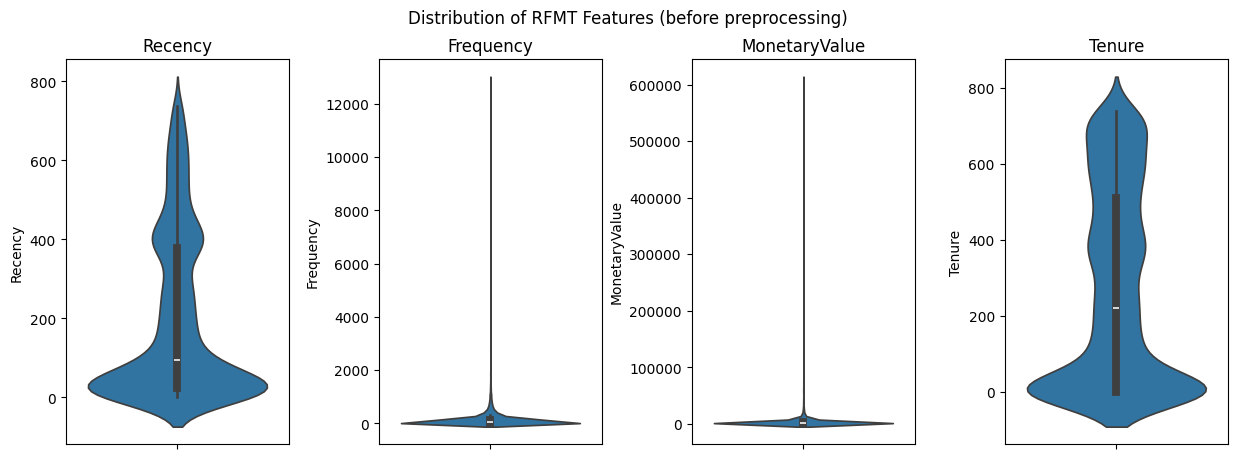

In [42]:
#| echo: false
num_features = rfmt.shape[1]
fig, axes = plt.subplots(1, num_features, figsize=(15,5))

for i, column in enumerate(rfmt.columns):
    sns.violinplot(y=rfmt[column], ax=axes[i])
    axes[i].set_title(column)

plt.suptitle('Distribution of RFMT Features (before preprocessing)')
plt.subplots_adjust(wspace=0.4)
plt.show()


**Log Transformation**
The RFMT metrics—especially monetary value and frequency—can exhibit right-skewed distributions, where a small number of high-value customers distort the overall picture. To mitigate this and to normalize the distribution of these attributes, we apply a log transformation. Log transformation dampens the impact of outliers and reduces skewness, making the underlying patterns more apparent and suitable for clustering.

Before applying the log transformation, we must ensure that there are no zero or negative values in the dataset, as the log function is not defined for these numbers. In such cases, we can add a constant (like 1) to all values to make the transformation feasible.

**Standardization**
Post log transformation, we perform standardization of the features. Standardization involves rescaling the data so that it has a mean of zero and a standard deviation of one. This is particularly important for distance-based clustering algorithms like K-means, which are sensitive to the scale of the data. If the features are on different scales, one feature might dominate the distance metric, leading to biased clusters.

By standardizing the features, we give each one equal weight in the clustering process. For RFMT data, this ensures that recency, which might be on the scale of days, is just as important as monetary value, which could be several orders of magnitude larger in raw units.

In [43]:
from sklearn.preprocessing import StandardScaler
log_rfmt = np.log1p(rfmt)
scaler = StandardScaler()
scaled_rfmt = pd.DataFrame(scaler.fit_transform(log_rfmt), columns=rfmt.columns, index=rfmt.index)

In [44]:
#| echo: false
# num_features = scaled_rfmt.shape[1]
# fig, axes = plt.subplots(1, num_features, figsize=(15,5))

# for i, column in enumerate(scaled_rfmt.columns):
#     sns.violinplot(y=scaled_rfmt[column], ax=axes[i])
#     axes[i].set_title(column)

# plt.suptitle('Distribution of RFMT Features (after preprocessing)')
# plt.subplots_adjust(wspace=0.4)
# plt.show()

### Selection of optimal *k*

To identify the optimal k – meaning the number of clusters in which we want to group our customers –, we use two primary methods: the Elbow Method with inertia as the metric, and Silhouette Scores.

**Elbow Method**: In this approach, we plot the inertia against the number of clusters. Inertia, which is a measure of the total distance of points from their respective cluster centroids, typically decreases as we increase the number of clusters. However, the rate of decrease sharply changes at a certain point, forming an 'elbow' in the plot. The optimal number of clusters is often considered to be at this 'elbow' point, where adding more clusters doesn't give much better modeling of the data. This method is intuitive and helps in visualizing the trade-off between the number of clusters and the compactness of the clusters.

**Silhouette Scores**: To complement the Elbow Method, we also use Silhouette Scores, which provide a quantitative measure of how well each object lies within its cluster. A high Silhouette Score suggests that the object is well matched to its own cluster and poorly matched to neighboring clusters. By evaluating the average Silhouette Score for different values of k, we can more accurately determine the number of clusters that optimally represents our data.

The combination of the Elbow Method using inertia and Silhouette Scores allows for a more comprehensive and reliable determination of the optimal number of clusters in our RFM customer segmentation. This dual approach ensures that we achieve a balance in our clustering model, avoiding both over-segmentation and under-segmentation.

In [45]:
#| echo: false

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters = list(range(2, 11))
sil_scores = []
sse = []
for k in n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=1, n_init='auto')
    kmeans.fit(scaled_rfmt)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(scaled_rfmt, kmeans.labels_))

k_sel_df = pd.DataFrame({'silhouette_score': sil_scores, 'sse': sse}, index=n_clusters)

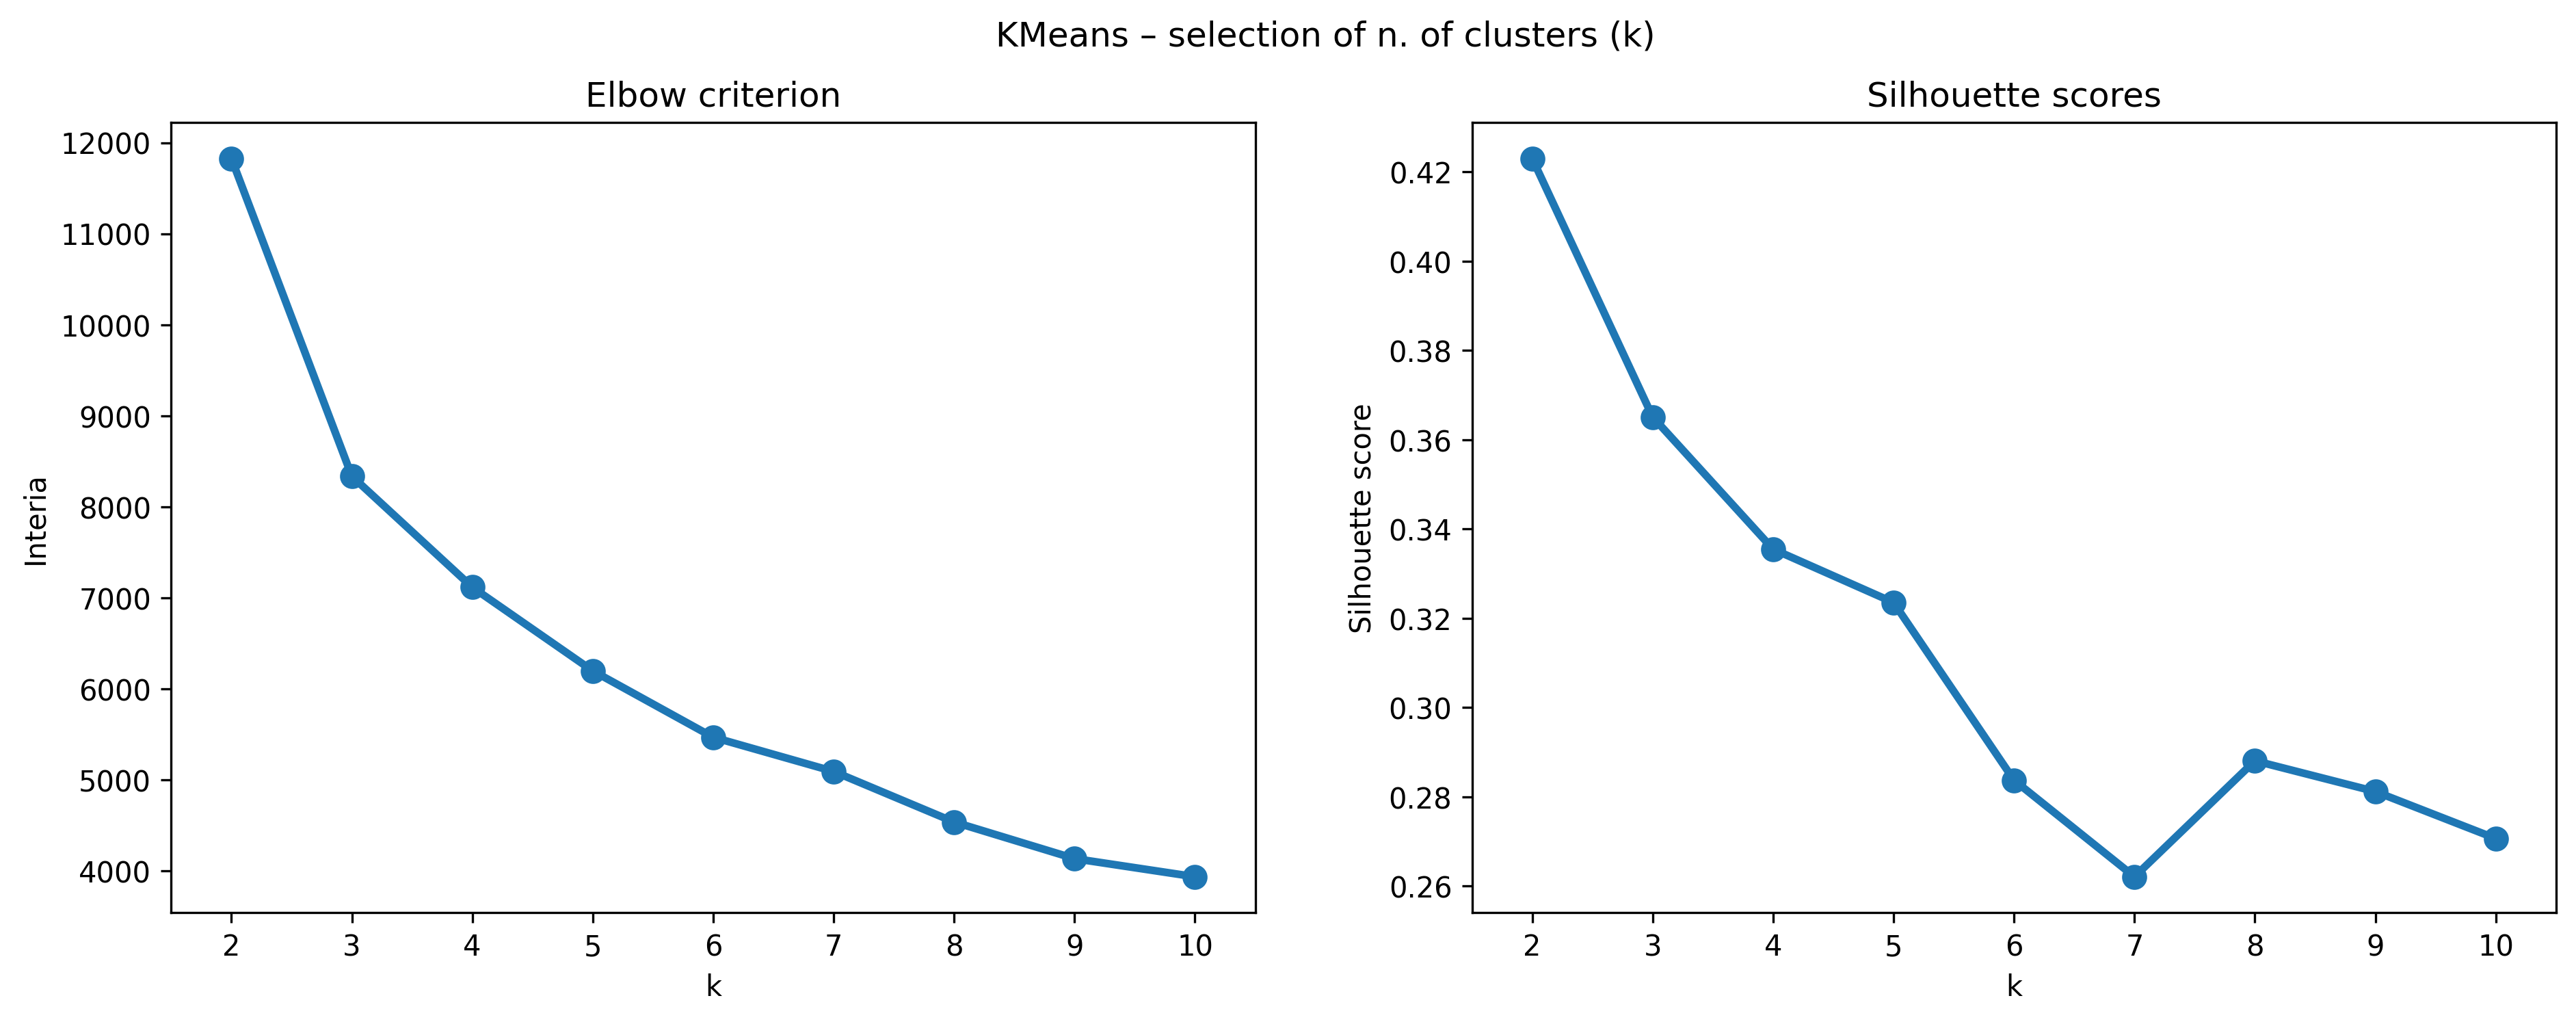

In [46]:
#| echo: false
fig, axes = plt.subplots(1,2, figsize=(15,5), dpi=300)

sns.pointplot(k_sel_df, x=k_sel_df.index, y='sse', ax=axes[0])
axes[0].set_title("Elbow criterion")
axes[0].set_xlabel('k'); axes[0].set_ylabel('Interia')

sns.pointplot(k_sel_df, x=k_sel_df.index, y='silhouette_score', ax=axes[1])
axes[1].set_title("Silhouette scores")
axes[1].set_xlabel('k'); axes[1].set_ylabel('Silhouette score')
plt.suptitle("KMeans – selection of n. of clusters (k)")
plt.show()

From the Elbow criterion graph, the optimal number of clusters k is typically chosen at the point where the inertia (sum of squared distances within clusters) begins to decrease more slowly, indicating diminishing returns on the distinctness of additional clusters. In the graph, there is no pronounced 'elbow,' but there seems to be a slight leveling off after k=4, suggesting that increasing the number of clusters beyond 4 yields smaller gains in compactness.

The Silhouette score provides a measure of how similar an object is to its own cluster compared to other clusters, with higher values indicating better-defined clusters. From the Silhouette scores graph, the score tends to decrease as k increases, which is expected as more clusters can lead to less cohesion within clusters. There is a noticeable uptick at k=5, but the score is still lower than for k=2,  k=3, and k=4.

Combining insights from both the Elbow method and the Silhouette scores, **k=4 seems to be a reasonable choice for the optimal number of clusters**. At this point, the inertia has not yet flattened out completely, and the Silhouette score, while not the highest, is relatively strong compared to higher k values. Therefore, k=4 could be considered a good balance between cluster distinctness and cohesion for this dataset.

But for the purpose of thorough analysis, we will conduct a **comparison between k=4 and k=3**. This comparison will help us to critically evaluate both statistical and practical aspects of the clustering results. By thoroughly investigating these two potential solutions, we will be able to determine which clustering solution is more appropriate for our customer segmentation.

### Predictions

We are going now to fit the KMeans algorithm with k=3 and k=4, and append the cluster predictions both to the original and scaled rfmt datasets.

In [47]:
rfmt_k = rfmt.copy()
k_cols = []
for k in [3, 4]:
    model = KMeans(n_clusters=k, random_state=1,  n_init='auto')
    col_name = f'k{k}'
    rfmt_k[f'k{k}'] = model.fit_predict(scaled_rfmt)
    k_cols.append(col_name)
scaled_rfmt_k = pd.concat([scaled_rfmt, rfmt_k.iloc[:, 4:]], axis=1)
rfmt_k

,Recency,Frequency,MonetaryValue,Tenure,k3,k4
CustomerID,,,,,,
12346.0,325,34,77556.46,400,1,1
12347.0,1,253,5633.32,402,1,1
12348.0,74,51,2019.40,362,2,2
12349.0,18,175,4428.69,570,1,1
12350.0,309,17,334.40,0,0,0
...,...,...,...,...,...,...
18283.0,3,986,2736.65,654,1,1
18284.0,431,28,461.68,0,0,0
18285.0,660,12,427.00,0,0,0


### Model comparison and interpretation of the clusters

In the subsequent analysis, we will delve into the interpretation of customer clusters as delineated by the KMeans clustering algorithm for k=3 and k=4, leveraging both heatmap and snakeplot visualizations. These visual tools are instrumental in uncovering the nuances of customer behavior across different segments. The heatmaps provide a clear, immediate visual representation of the mean values of the RFM (Recency, Frequency, Monetary value) metrics and Tenure for each cluster, highlighting patterns through color intensity — darker shades indicate higher mean values within a cluster relative to others. In contrast, the snakeplots will allow us to understand the relative positioning of each cluster along the RFM and Tenure dimensions through a line plot, offering a more detailed and comparative view of the clusters' profiles. This juxtaposition of visual techniques will enable us to draw a comprehensive picture of the clusters, identify key characteristics that define each segment, and infer the strategic implications for targeted marketing actions.

#### Model comparison

In [48]:
#| echo: false

kns = [col for col in rfmt_k.columns[4:]]
k_summaries = {col:rfmt_k.groupby(col).mean().reset_index(drop=True).iloc[:, :-len(kns)+1] 
               for col in kns}
scaled_k_summaries = {col:scaled_rfmt_k.groupby(col).median().reset_index(drop=True).iloc[:, :-len(kns)+1] 
                      for col in kns}

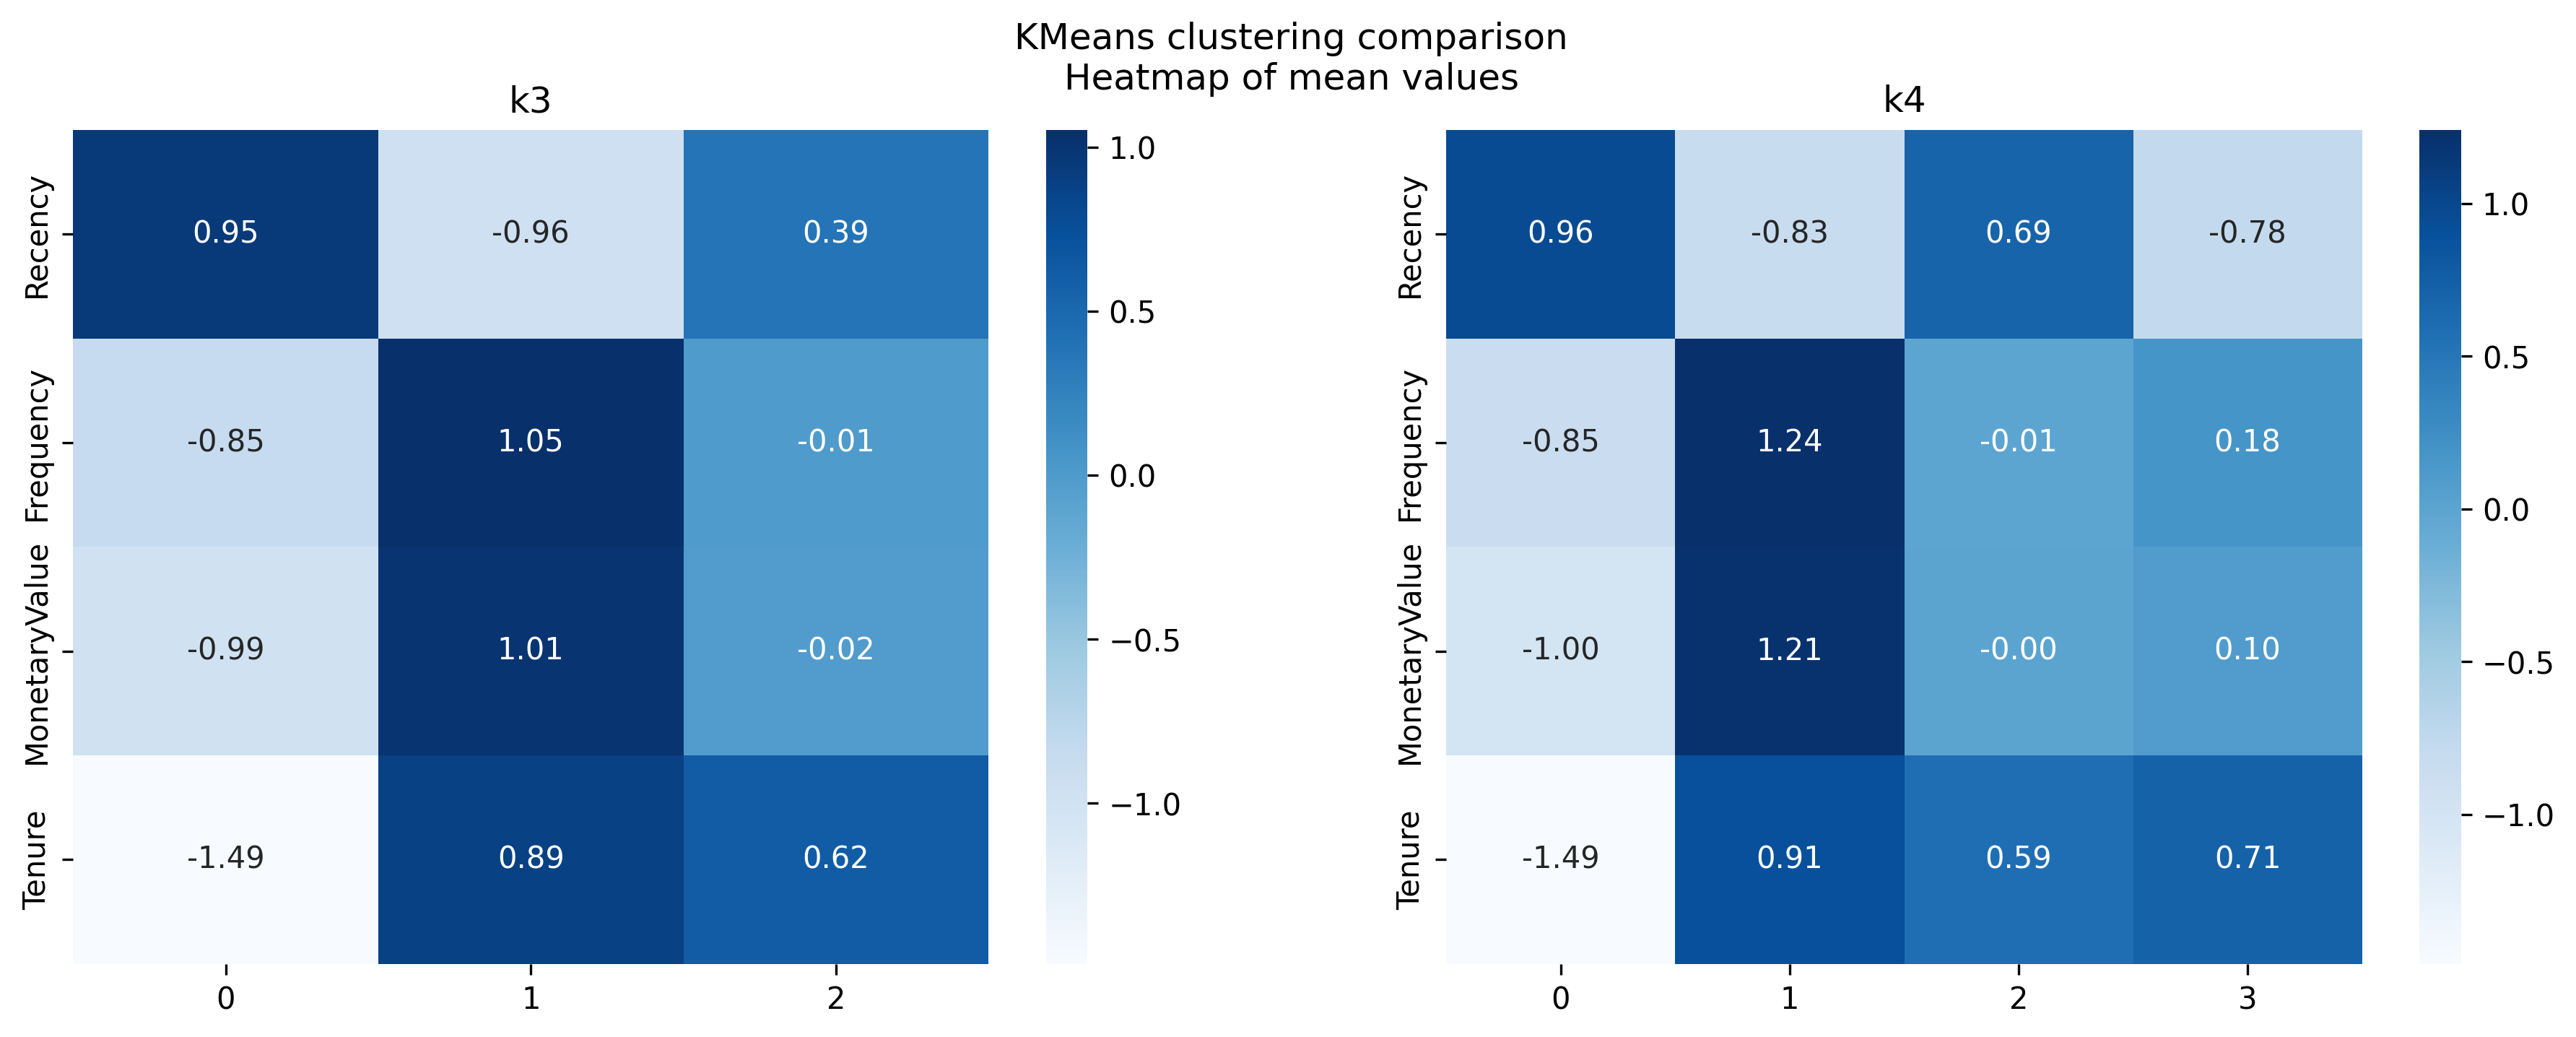

In [49]:
#| echo: false
fig, ax = plt.subplots(1, len(kns), figsize=(15,5), dpi=300)
for n, kn in enumerate(k_summaries.keys()):
    sns.heatmap(scaled_k_summaries[kn].T, annot=True, fmt='.2f', ax=ax[n], cmap='Blues', )
    ax[n].set_title(kn)
plt.suptitle("KMeans clustering comparison\nHeatmap of mean values")
plt.show()

In [50]:
#| echo: false

scaled_rfmt_k_melted = scaled_rfmt_k.reset_index().melt(id_vars=['CustomerID'] + kns, value_vars=['Recency', 'Frequency', 'MonetaryValue', 'Tenure'], var_name='Attribute', value_name='Value')
scaled_rfmt_k_melted[kns] = scaled_rfmt_k_melted[kns].astype('category')

rfmt_k_melted = rfmt_k.reset_index().melt(id_vars=['CustomerID'] + kns, value_vars=['Recency', 'Frequency', 'MonetaryValue', 'Tenure'], var_name='Attribute', value_name='Value')
rfmt_k_melted[kns] = rfmt_k_melted[kns].astype('category')

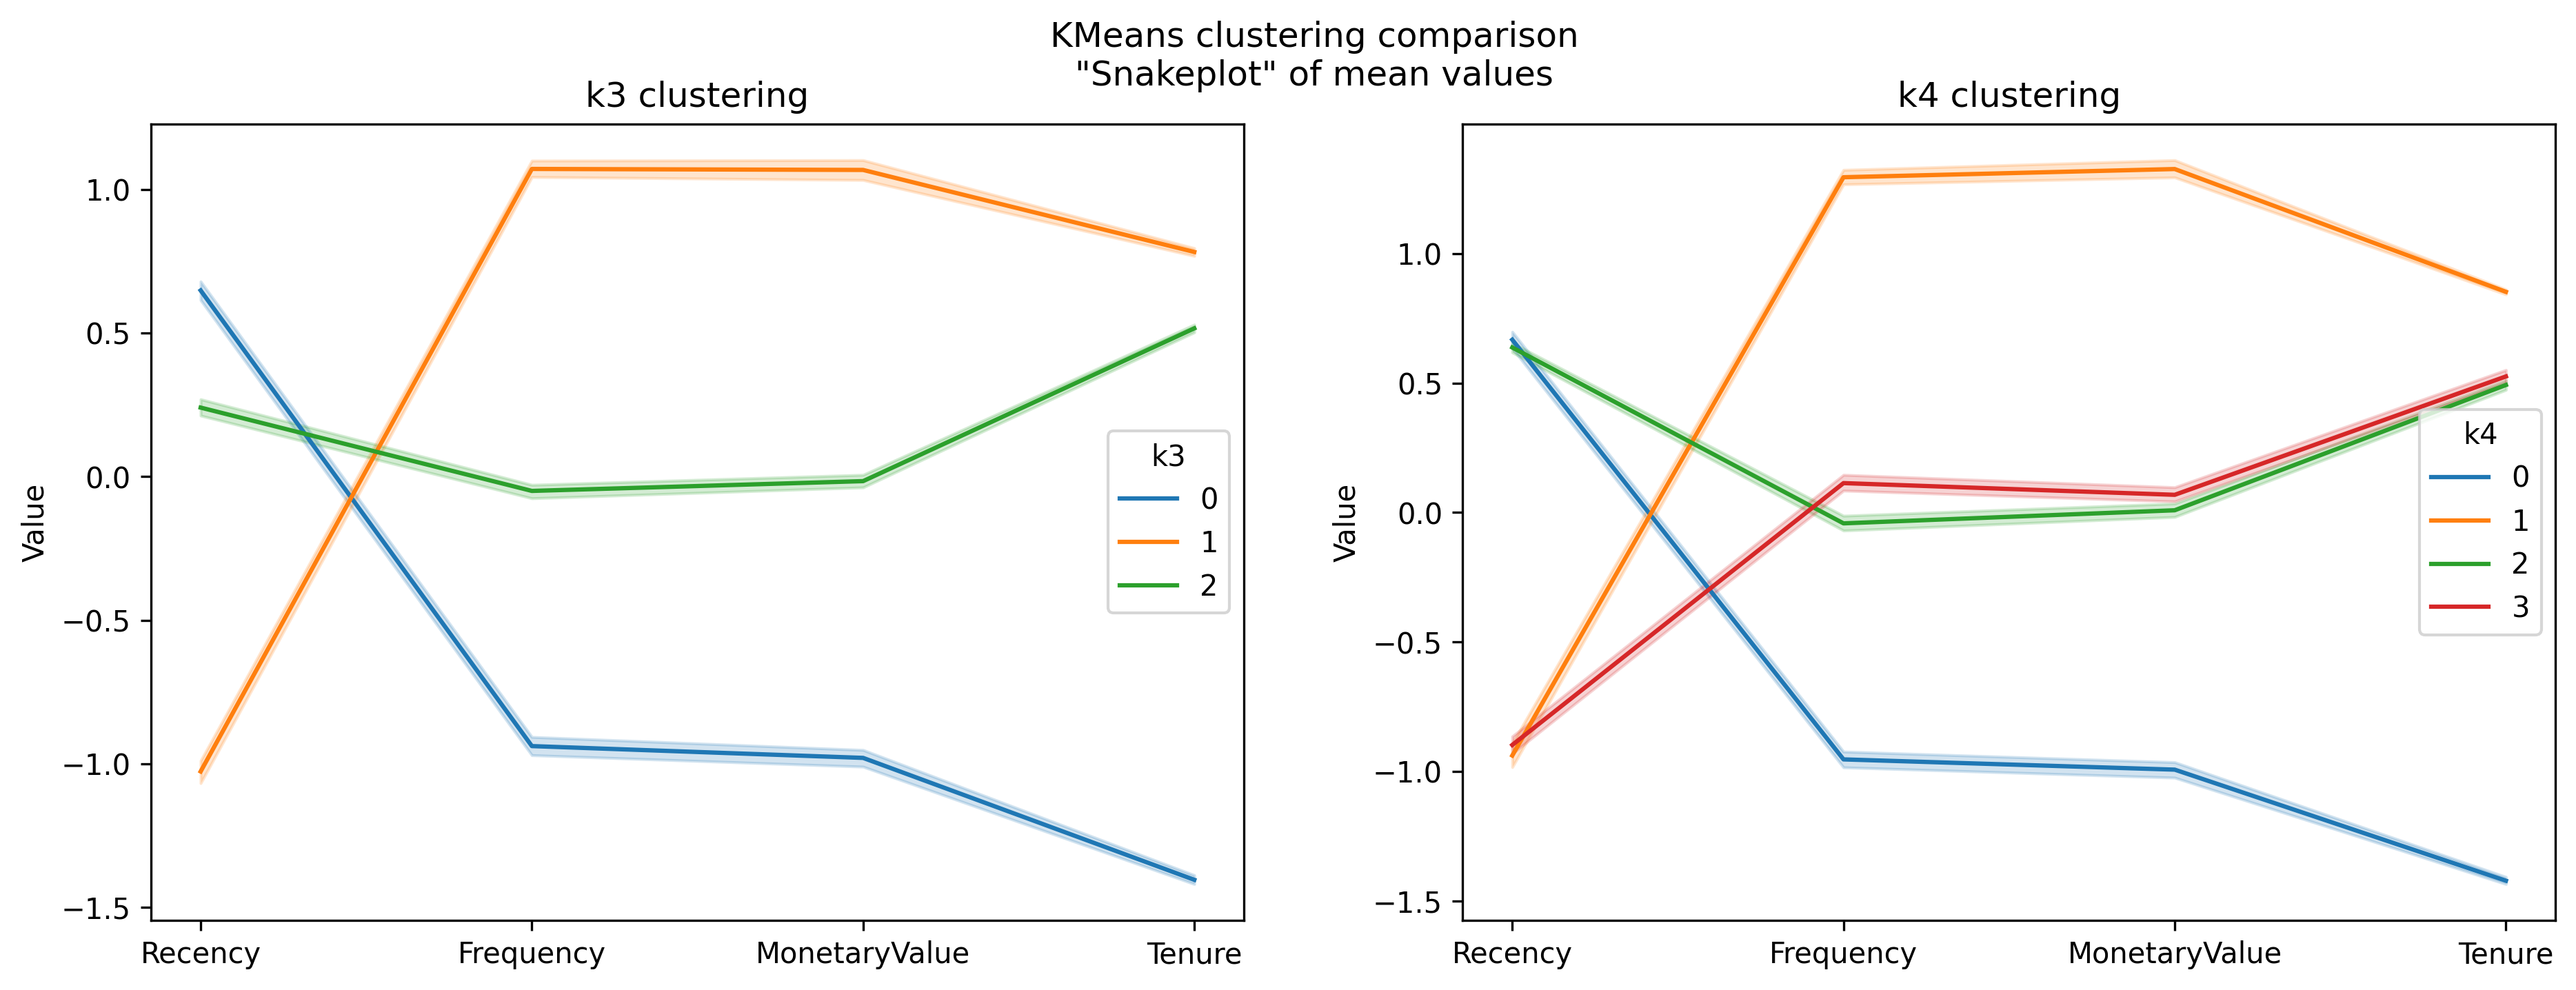

In [51]:
#| echo: false
fig, ax = plt.subplots(1, len(kns), figsize=(15,5), dpi=300)
for n, kn in enumerate(k_summaries.keys()):
    sns.lineplot(scaled_rfmt_k_melted, x='Attribute', y='Value', hue=kn, ax=ax[n])
    ax[n].set_xlabel('');
    ax[n].set_title(f"{kn} clustering")
plt.suptitle('KMeans clustering comparison\n"Snakeplot" of mean values')
plt.show()

When comparing the clusters between k=3 and k=4, it's evident that the introduction of a fourth cluster (the red cluster in k=4) provides a finer segmentation of the customer base, specifically related to the green cluster (of k=3).

#### Interpretation of clusters

Having established that the k=4 model offers a more granular and insightful segmentation of the customer base, let's proceed with a detailed interpretation of each cluster and propose targeted actions for each.

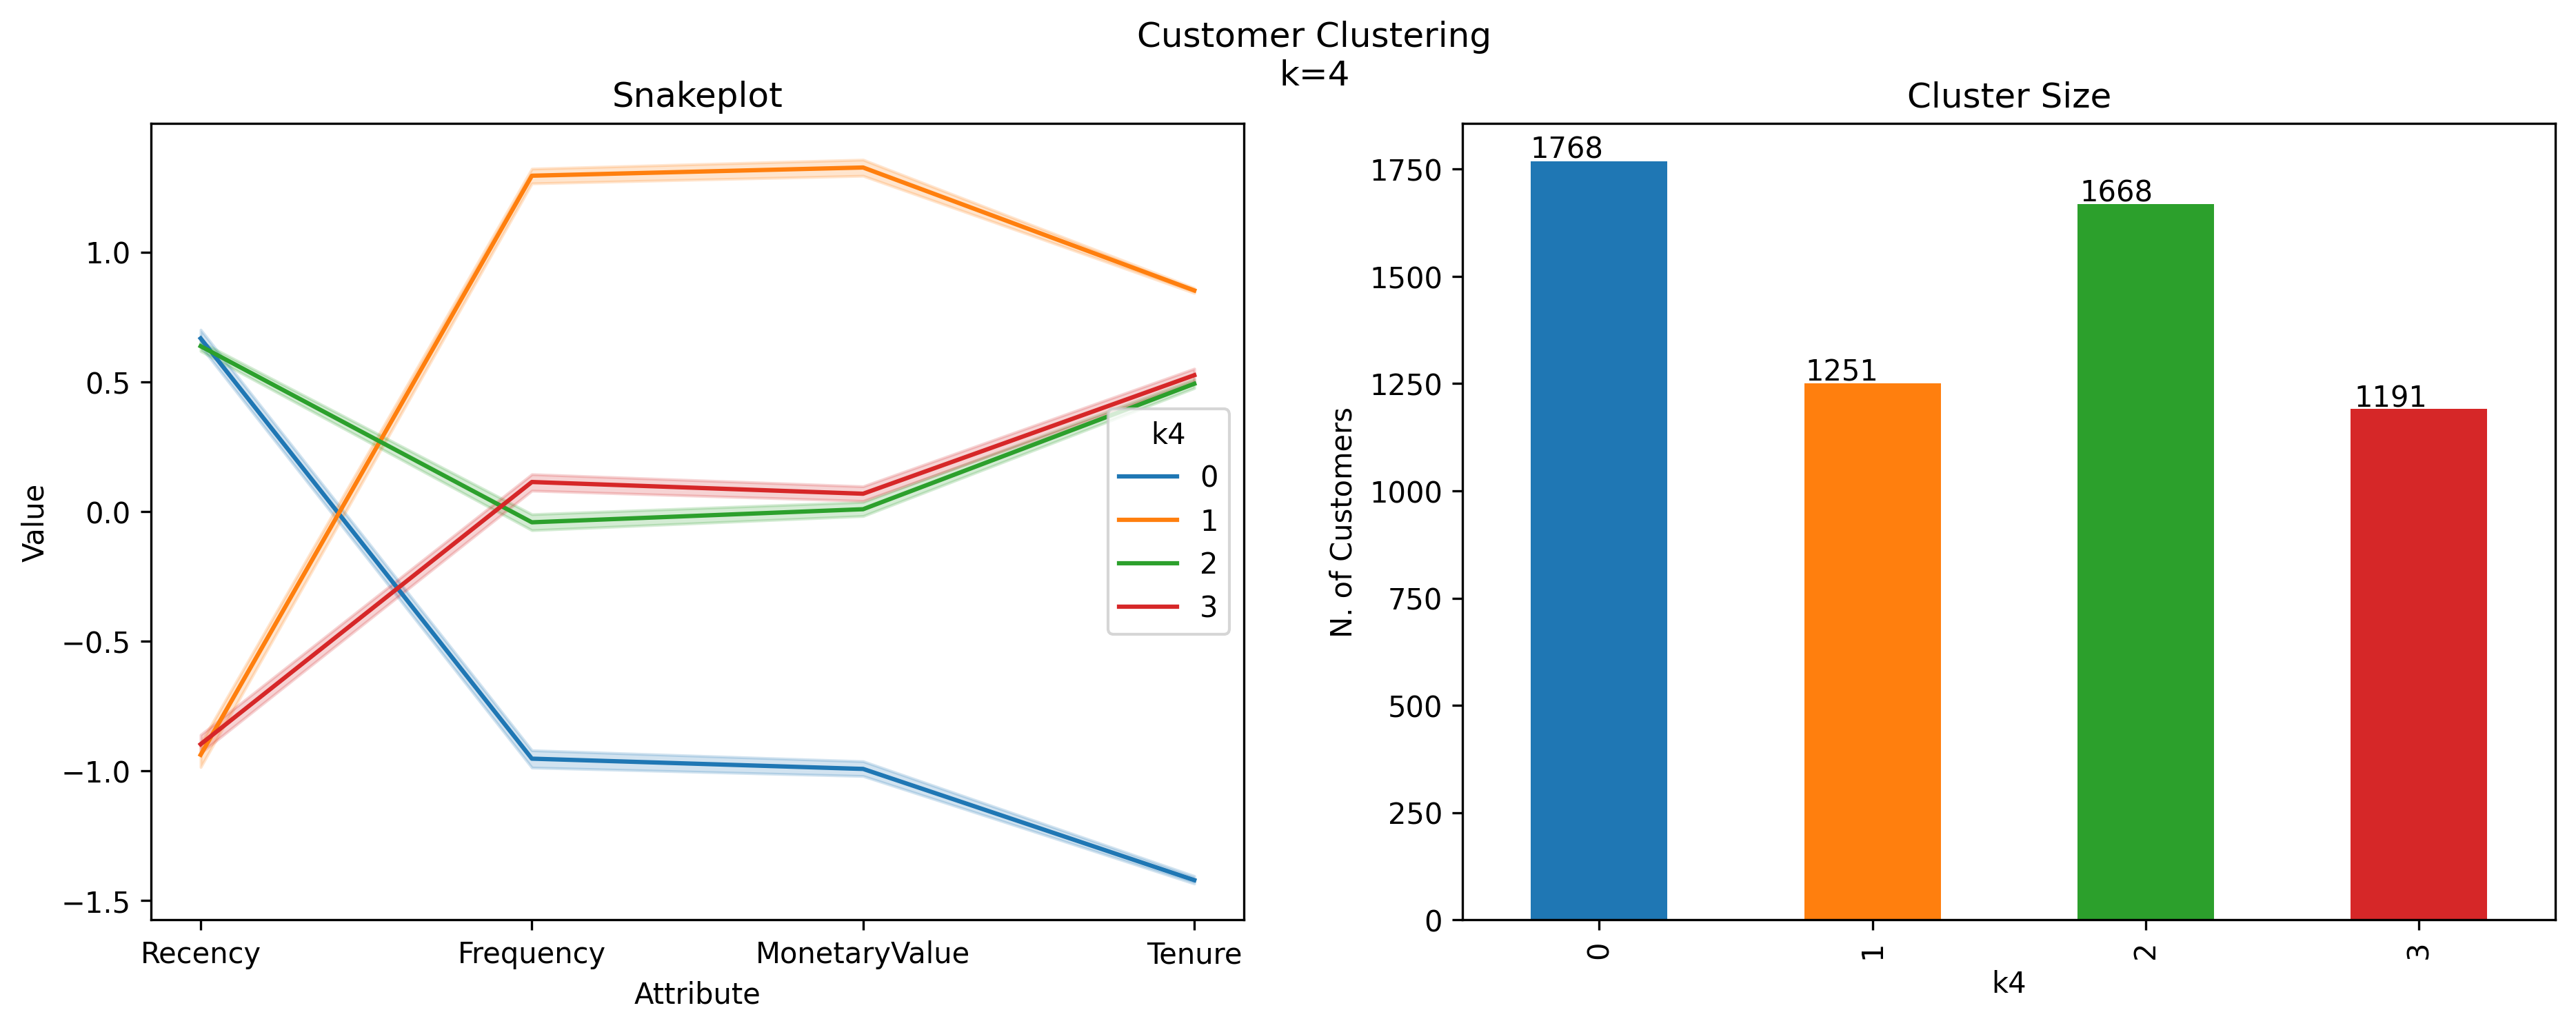

In [52]:
#| echo: false

fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

# Snakeplot
sns_plot = sns.lineplot(data=scaled_rfmt_k_melted, x='Attribute', y='Value', hue=kn, ax=ax[0])
ax[0].set_title('Snakeplot')

# Extract the colors used in the snakeplot
palette = sns_plot.get_legend().legend_handles
hue_colors = {h.get_label(): h.get_color() for h in palette}

# Bar plot
grouped_data = scaled_rfmt_k.groupby('k4').size()
bar_plot = grouped_data.plot(kind='bar', ax=ax[1], color=[hue_colors[str(i)] for i in grouped_data.index])

# Annotating each bar
for p in ax[1].patches:
    ax[1].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

ax[1].set_title('Cluster Size')
ax[1].set_ylabel('N. of Customers')
plt.suptitle('Customer Clustering\nk=4')
plt.show()

The following table summarizes the clusters' features and proposes related business personas.

| Cluster | Recency | Frequency | MonetaryValue | Tenure | Size | Business Persona |
|---------|---------|-----------|---------------|--------|------|------------------|
|0|High|Low|Low|Low|Large|New Potential Customers|
|1|Low|High|High|High|Medium|Loyal High-Value/Engagement Customers|
|2|High|Medium|Medium|Medium|Large|At-Risk Medium-Value/Engagement Customers|
|3|Low|Medium|Medium|Medium|Medium|Loyal Medium-Value/Engagement Customers|

**New Potential Customers (Cluster 0)**

* *Description*: This large cluster consists of recently acquired customers with low frequency and monetary value, and with no recent interactions.
* *Actions*: Implement a nurturing strategy to foster these new relationships. Introduce onboarding programs, provide educational content, and send tailored promotions to encourage repeat purchases and increase monetary value.

**Loyal High-Value/Engagement Customers (Cluster 1)**

* *Description*: A medium-sized group of customers with high frequency, monetary value, and tenure, showing strong loyalty and engagement.
* *Actions*: Develop retention programs with exclusive rewards, recognize loyalty milestones, and offer referral incentives. Engage them with personalized communication and consider involving them in product development feedback loops to maintain their high engagement.

**At-Risk Medium-Value/Engagement Customers (Cluster 2)**

* *Description*: Another large cluster, these customers have medium values for frequency, monetary value, and tenure but have engaged less recently. They might be at-risk of churn.
* *Actions*: Reactivate these customers with "we miss you" messages, offering updates on what they've missed. Provide incentives that encourage them to revisit and transact, such as limited-time offers or exclusive previews of new products.

**Loyal Medium-Value/Engagement Customers (Cluster 3)**

* *Description*: A medium-sized cluster with low recency but medium frequency, monetary value, and tenure, indicating constant engagement.
* *Actions*: Design engagement campaigns highlighting new offerings or loyalty rewards. Conduct surveys to understand their recent interaction and potential risks. Offer incentives for increased frequency and spending.

Each cluster requires a tailored approach that aligns with the behavior patterns identified through the RFM and Tenure analysis. The goal is to enhance customer value across all segments, whether by nurturing new relationships, retaining valuable customers, or re-engaging those showing signs of decreasing engagement. By taking these specific, data-driven actions, the business can optimize its marketing efforts and improve the overall customer lifecycle value.